In [1]:
import pyrealsense2 as rs
import cv2
import numpy as np
from math import tan, pi
import matplotlib.pyplot as plt

In [2]:
ctx = rs.context()
devices = ctx.query_devices()

In [3]:
var = [i.get_info(rs.camera_info.serial_number) for i in devices]

In [5]:
var

['923322071362', '836612071597']

In [6]:
def get_extrinsics(src,dst):
    extrinsics = src.get_extrinsics_to(dst)
    R = np.reshape(extrinsics.rotation, [3,3]).T
    T = np.array(extrinsics.translation)
    return (R,T)

In [7]:
#returns camera matrix from intrinsics
def camera_matrix(intrinsics):
    return np.array([[intrinsics.fx, 0, intrinsics.ppx],
                     [0, intrinsics.fy, intrinsics.ppy],
                    [0,0,1]])

In [8]:
def callback(frame):
    global frame_data
    if frame.is_frameset():
        frameset = frame.as_frameset()
        f1 = frameset.as_video_frame()
        f2 = frameset.as_video_frame()
        left_data = np.asanyarray(f1.get_data())
        right_data = np.asanyarray(f2.get_data())
        ts = frameset.get_timestap()
        frame_data["left"] = left_data
        frame_data["right"] = right_data
        frame_data["timestamp"] = ts
        frame_mutex.release()

In [15]:
pipe = rs.pipeline()
pipe2 = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 90)
cfg2 = rs.config()
cfg2.enable_stream(rs.stream.depth, 848,480, rs.format.z16, 90)
pipe.start(cfg, callback)
pipe2.start(cfg2, callback)

RuntimeError: xioctl(VIDIOC_S_FMT) failed Last Error: Device or resource busy

In [ ]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 90)
pipe.start(cfg, callback)
print('pipeline set up')

In [14]:
profiles = pipe.get_active_profile()

NameError: name 'pipe' is not defined

In [13]:
profiles.get_streams(rs.stream.fisheye,1)


TypeError: get_streams(): incompatible function arguments. The following argument types are supported:
    1. (self: pyrealsense2.pyrealsense2.pipeline_profile) -> List[pyrealsense2.pyrealsense2.stream_profile]

Invoked with: <pyrealsense2.pyrealsense2.pipeline_profile object at 0x7fd02b41f030>, stream.fisheye, 1

In [10]:
try:
    #retrieve stream and intrinsic properties
    profiles = pipe.get_active_profile()
    #profiles2 = pipe2.get_active_profile()
    streams = {"left": profiles.get_streams(rs.stream.depth,1).as_video_stream_profile(),
              "right": profiles.get_streams(rs.stream.depth,2).as_video_stream_profile()}
    intrinsics = {"left": streams["left"].get_intrinsics(),
                 "right": streams["right"].get_intrinsics()}
    
    
    print("Left camera:", intrinsics["left"])
    print("Right camera:", intrinsics["right"])
    
    K_left = camera_matrix(intrinsics["left"])
    K_right = camera_matrix(intrinsics["right"])
    
    (R,T) = get_extrinsics(streams["left"], streams["right"])
    print("rotation matrix:", R)
    print("translation matrix:", T)

finally:
    pipe.stop()
    del pipe
    del cfg

TypeError: get_streams(): incompatible function arguments. The following argument types are supported:
    1. (self: pyrealsense2.pyrealsense2.pipeline_profile) -> List[pyrealsense2.pyrealsense2.stream_profile]

Invoked with: <pyrealsense2.pyrealsense2.pipeline_profile object at 0x7fd02b41f030>, stream.depth, 1

In [10]:
#transform points from one coordinate space to another after knowing extrinsics
#standard affine transformation using a 3x3 rotation matrix and 3-component translation vector
rs.rs2_transform_point_to_point()

TypeError: rs2_transform_point_to_point(): incompatible function arguments. The following argument types are supported:
    1. (extrin: pyrealsense2.pyrealsense2.extrinsics, from_point: List[float[3]]) -> List[float[3]]

Invoked with: 

In [20]:
#deprojection - 2D pixel location + depth and maps it to 3D point location
rs.rs2_deproject_pixel_to_point()

TypeError: rs2_deproject_pixel_to_point(): incompatible function arguments. The following argument types are supported:
    1. (intrin: pyrealsense2.pyrealsense2.intrinsics, pixel: List[float[2]], depth: float) -> List[float[3]]

Invoked with: 

(480, 848, 3)


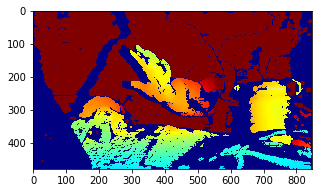

In [4]:
#affine transformation
import PIL
img = plt.imread('depth1.jpg')
print(img.shape)
plt.figure(figsize = (5,5))
plt.imshow(img)

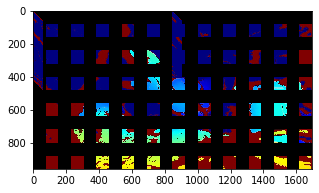

In [18]:
T = np.array([[2,0,0],[0,2,0],[0,0,1]])
new_img = np.empty((480*2,848*2,3),dtype = np.uint8)
for i, row in enumerate(img):
    for j, col in enumerate(row):
        pixel_data = img[i,j,:]
        input_coords = np.array([i,j,1])
        i_out, j_out, _ = T @ input_coords
        new_img[i_out, j_out, :] = pixel_data
plt.figure(figsize = (5,5))
plt.imshow(new_img)

In [5]:
T_pos = np.array([[1,0,1000],[0,1,1000],[0,0,1]])
T_rot = np.array([[0,-1,0],[1,0,0],[0,0,1]])
T_scale = np.array([[1,0,0],[0,1,0],[0,0,1]])
T_neg = np.array([[1,0,-500],[0,1,-500],[0,0,1]])
T = T_pos @ T_rot @ T_scale @ T_neg
T_inv = np.linalg.inv(T)
T_inv.flatten()[:6]

array([ 0.0e+00,  1.0e+00, -5.0e+02, -1.0e+00, -0.0e+00,  1.5e+03])

In [8]:
#using opencv
img = cv2.imread('depth1.jpg')
rows, cols, ch = img.shape

#translation
M = np.float32([[1,0,100],[0,1,50]])
dst = cv2.warpAffine(img, M, (cols,rows))
cv2.imshow('img',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
#rotation by 90 degrees
M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
dst = cv2.warpAffine(img, M, (cols,rows))
cv2.imshow('img',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

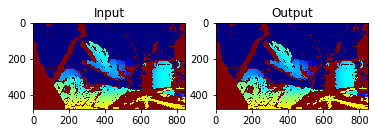

In [11]:
#affine transformation 
#need 3 points in original image to map to new image
pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])

M = cv2.getAffineTransform(pts1,pts2)
dst = cv2.warpAffine(img, M, (cols,rows))
plt.subplot(121), plt.imshow(img), plt.title('Input')
plt.subplot(122), plt.imshow(img), plt.title('Output')
plt.show()

In [9]:
#cam1: configure depth and color streams 
pipeline1 = rs.pipeline()
config1 = rs.config()
config1.enable_device(var[0])
config1.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 90)
config1.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 60)
config1.enable_record_to_file('multicam1.bag')
print('cam1 enabled')

cam1 enabled


In [10]:
#cam1: configure depth and color streams 
pipeline2 = rs.pipeline()
config2 = rs.config()
config2.enable_device(var[1])
config2.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 90)
config2.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 60)
config2.enable_record_to_file('multicam2.bag')
print('cam2 enabled')

cam2 enabled


In [11]:
#start stream
pipeline1.start(config1)
pipeline2.start(config2)
print('cams configured')

cams configured


In [12]:
frames1 = pipeline1.wait_for_frames()
depthframe1 = frames1.get_depth_frame()
colframe1 = frames1.get_color_frame()

In [13]:
frames2 = pipeline2.wait_for_frames()
depthframe2 = frames2.get_depth_frame()
colframe2 = frames2.get_color_frame()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(480, 848)


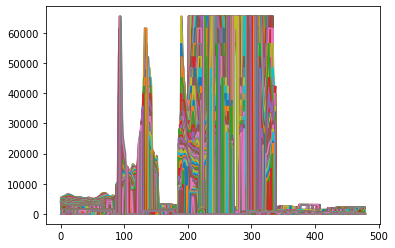

In [45]:
#get depth info for each pixel from cam1
depth_data = depthframe1.as_frame().get_data()
np.image = np.asanyarray(depth_data)
print(np.image)
print(np.image.shape)
plt.plot(np.image)
plt.show()

In [37]:
#get depth info for each pixel from cam2
depth_data2 = depthframe2.as_frame().get_data()
np.image2 = np.asanyarray(depth_data2)
print(np.image2)

[[   0    0    0 ...    0    0    0]
 [   0    0    0 ... 1033 1031    0]
 [   0    0    0 ... 1033 1033    0]
 ...
 [   0    0    0 ...  434    0    0]
 [   0    0    0 ...  434    0    0]
 [   0    0    0 ...    0    0    0]]


In [60]:
#depth is stored as one unsigned 16-bit integer per pixel
#distance in meters
#retrieve the depth of pixels in meters
#depth scale - units of the values inside depth frame
depth_sensor = pipe_profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
depth_scale

NameError: name 'pipe_profile' is not defined

In [8]:
#map depth to color
depth_pixel = [240,320] #random point
depth_point = rs.rs2_deproject_pixel_to_point(depth_intrin, depth_pixel, depth_scale)
color_point = rs.rs2_transform_point_to_point(depth_to_color_extrin, depth_point)
color_pixel = rs.rs2_project_point_to_pixel(color_intrin, color_point)
pipeline.stop()

In [9]:
print(depth_point)
print(color_point)
print(color_pixel)

[-0.0006133948918431997, -7.135550549719483e-05, 0.0010000000474974513]
[0.014311893843114376, 0.0003776001394726336, 0.0008590113138779998]
[10583.90625, 507.1816711425781]


In [ ]:
cv2.calibrateCamera